# DATA20001 Deep Learning - Group Project
## Text project

**Due Thursday, December 13, before 23:59.**

The task is to learn to assign the correct labels to news articles.  The corpus contains ~850K articles from Reuters.  The test set is about 10% of the articles. The data is unextracted in XML files.

We're only giving you the code for downloading the data, and how to save the final model. The rest you'll have to do yourselves.

Some comments and hints particular to the project:

- One document may belong to many classes in this problem, i.e., it's a multi-label classification problem. In fact there are documents that don't belong to any class, and you should also be able to handle these correctly. Pay careful attention to how you design the outputs of the network (e.g., what activation to use) and what loss function should be used.
- You may use word-embeddings to get better results. For example, you were already using a smaller version of the GloVE  embeddings in exercise 4. Do note that these embeddings take a lot of memory. 
- In the exercises we used e.g., `torchvision.datasets.MNIST` to handle the loading of the data in suitable batches. Here, you need to handle the dataloading yourself.  The easiest way is probably to create a custom `Dataset`. [See for example here for a tutorial](https://github.com/utkuozbulak/pytorch-custom-dataset-examples).

## Download the data

In [96]:
import os
import torch
from torchvision.datasets.utils import download_url
import zipfile

train_path = 'train/'

dl_file='reuters.zip'
dl_url='https://www.cs.helsinki.fi/u/jgpyykko/'
zip_path = os.path.join(train_path, dl_file)
if not os.path.isfile(zip_path):
    download_url(dl_url + dl_file, root=train_path, filename=dl_file, md5=None)

with zipfile.ZipFile(zip_path) as zip_f:
    zip_f.extractall(train_path)
    #os.unlink(zip_path)

The above command downloads and extracts the data files into the `train` subdirectory.

The files can be found in `train/`, and are named as `19970405.zip`, etc. You will have to manage the content of these zips to get the data. There is a readme which has links to further descriptions on the data.

The class labels, or topics, can be found in the readme file called `train/codes.zip`.  The zip contains a file called "topic_codes.txt".  This file contains the special codes for the topics (about 130 of them), and the explanation - what each code means.  

The XML document files contain the article's headline, the main body text, and the list of topic labels assigned to each article.  You will have to extract the topics of each article from the XML.  For example: 
&lt;code code="C18"&gt; refers to the topic "OWNERSHIP CHANGES" (like a corporate buyout).

You should pre-process the XML to extract the words from the article: the &lt;headline&gt; element and the &lt;text&gt;.  You should not need any other parts of the article.

## Imports

In [1]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
import numpy as np
import xml.etree.ElementTree as ET
import pandas as pd
import time
import matplotlib.pyplot as plt

## Data preprocessing
This processes the zips in `train/` without additional extractions to disk and produces a pandas dataframe with results. Finally this dataframe is written to disk in a compressed form for subsequent use.

In [37]:
def getHeadline(root):
    return root.find('headline').text

def getTitle(root):
    return root.find('title').text

def getCodes(root):
    metaElem = root.find('metadata')
    codesElem = metaElem.findall('codes')
    codes = []
    for c in codesElem:
        # Get only topic codes
        if c.attrib['class'] == 'bip:topics:1.0':
            for code in c:
                codes.append(code.attrib['code'])
    return codes

def getText(root):
    ps = root.find('text').findall('p')
    text = []
    for p in ps:
        text.append(p.text)
    return '\n'.join(text)

def parseXML(file):
    root = ET.parse(file).getroot()
    return getHeadline(root), getTitle(root), getText(root), getCodes(root)

def parseZip(file):
    zf = zipfile.ZipFile(file, 'r')
    for xml in zf.namelist():
        h,t,txt,cs = parseXML(zf.open(xml))
        headlines.append(h)
        titles.append(t)
        texts.append(txt)
        codes.append(cs)

In [97]:
data_path = 'train/REUTERS_CORPUS_2/'
headlines, titles, texts, codes = [], [], [], []
print('Processing data in', data_path)
for f in os.listdir(data_path):
    if f.startswith("1997") and f.endswith(".zip"):
        print('.', end='')
        parseZip(data_path+f)

df = pd.DataFrame({'headline': headlines, 'title': titles, 'text': texts, 'codes': codes})
print('\nCompressing dataframe to train/train.json.xz')
df.to_json('train/train.json.xz', orient='records', compression='xz')
df.head()

Processing data in train/REUTERS_CORPUS_2/
...............................................................................................................................
Compressing dataframe to train/train.json.xz


,headline,title,text,codes
0,Tokyo stocks likely to rise after Dow rebound.,JAPAN: Tokyo stocks likely to rise after Dow r...,Tokyo stocks are likely to rise in Tuesday's s...,"[M11, MCAT]"
1,OFFICIAL JOURNAL CONTENTS - OJ C 111 OF APRIL ...,EU: OFFICIAL JOURNAL CONTENTS - OJ C 111 OF A...,*\nCommon position (EC) No 11/97 of 20 Decembe...,"[G15, GCAT]"
2,OFFICIAL JOURNAL CONTENTS - OJ C 113 OF APRIL ...,EU: OFFICIAL JOURNAL CONTENTS - OJ C 113 OF A...,*\nEcu (97/C 113/01)\nProposal for a Council D...,"[G15, GCAT]"
3,OFFICIAL JOURNAL CONTENTS - OJ C 114 OF APRIL ...,EU: OFFICIAL JOURNAL CONTENTS - OJ C 114 OF A...,*\n(Note - contents are displayed in reverse o...,"[G15, GCAT]"
4,OFFICIAL JOURNAL CONTENTS - OJ L 97 OF APRIL 1...,EU: OFFICIAL JOURNAL CONTENTS - OJ L 97 OF AP...,*\n(Note - contents are displayed in reverse o...,"[G15, GCAT]"


## Load a preprocessed dataframe

In [2]:
df = pd.read_json('train/train.json.xz', compression='xz')
#df = df.sample(frac=0.2) # Uncomment to work with a smaller subset of data
df.head()

,codes,headline,text,title
0,"[M11, MCAT]",Tokyo stocks likely to rise after Dow rebound.,Tokyo stocks are likely to rise in Tuesday's s...,JAPAN: Tokyo stocks likely to rise after Dow r...
1,"[G15, GCAT]",OFFICIAL JOURNAL CONTENTS - OJ C 111 OF APRIL ...,*\nCommon position (EC) No 11/97 of 20 Decembe...,EU: OFFICIAL JOURNAL CONTENTS - OJ C 111 OF A...
2,"[G15, GCAT]",OFFICIAL JOURNAL CONTENTS - OJ C 113 OF APRIL ...,*\nEcu (97/C 113/01)\nProposal for a Council D...,EU: OFFICIAL JOURNAL CONTENTS - OJ C 113 OF A...
3,"[G15, GCAT]",OFFICIAL JOURNAL CONTENTS - OJ C 114 OF APRIL ...,*\n(Note - contents are displayed in reverse o...,EU: OFFICIAL JOURNAL CONTENTS - OJ C 114 OF A...
4,"[G15, GCAT]",OFFICIAL JOURNAL CONTENTS - OJ L 97 OF APRIL 1...,*\n(Note - contents are displayed in reverse o...,EU: OFFICIAL JOURNAL CONTENTS - OJ L 97 OF AP...


## Some clean up

Let's put here the preprocessing we want to do to our data. For example, there are few items with no headline... Replace with " ".

In [3]:
df[df['headline'].isnull()]

,codes,headline,text,title
54188,[],None,"LONDON, Reuter - Following are the buying and ...",None
139410,[],None,General Dynamics Corp bid about $1 billion for...,USA:
191484,"[E21, E212, ECAT, M11, MCAT]",None,:Delhi shares surge after budget clears parlia...,INDIA:
194718,"[M11, MCAT]",None,INDIA: Delhi shares rise in hectic afternoon t...,INDIA:
248396,"[G154, G155]",None,The future cost of state funding of pensions i...,FRANCE:
274094,"[M11, MCAT]",None,Leading British stocks look set to continue th...,UK:


In [4]:
df[df['title'].isnull()]

,codes,headline,text,title
54188,[],None,"LONDON, Reuter - Following are the buying and ...",None


In [5]:
def clean_df(df):
    df.headline.fillna(value=" ", inplace=True)
    df.title.fillna(value=" ", inplace=True)

    re_dict = {"\n": " ",
               "\t": " ",
               "\'s": " \'s",
               "?": " ? ",
               ".": " . ",
               ",": " , ",
               '"': ' " ',
               ":": " : ",
               "*": " * ",
               "(": " ( ", ")": " ) ", "$": " $ ", "/": " / "}
    for to_replace, replacement in re_dict.items():
        df.text = df.text.str.replace(to_replace, replacement)
        df.headline = df.headline.str.replace(to_replace, replacement)

    return df

df = clean_df(df)

## What are we dealing with?
Lengths of headlines

In [6]:
df.headline.apply(len).describe()

count    299773.000000
mean         47.518756
std           7.281638
min           1.000000
25%          43.000000
50%          49.000000
75%          53.000000
max         162.000000
Name: headline, dtype: float64

Lengths of text fields. There seems to be a few light year long items.

In [7]:
df.text.apply(len).describe()

count    299773.000000
mean       1533.312753
std        1394.437257
min           0.000000
25%         618.000000
50%        1149.000000
75%        2066.000000
max       55120.000000
Name: text, dtype: float64

How many codes items have? Most have a handful but some can have 10x more.

count    299773.000000
mean          3.202697
std           1.399520
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          16.000000
Name: codes, dtype: float64


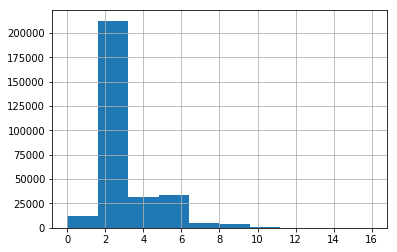

In [8]:
print(df.codes.apply(len).describe())
df.codes.apply(len).hist()

How many different codes are in data?

In [8]:
codesList = df.codes.values
codes = []
for cs in codesList:
    codes += cs
print(len(set(codes)))

103


How about in the text files that give labels for these codes? I have gathered these in one file, `topic_codes.txt`.

In [6]:
topic_codes = []
with open('train/topic_codes.txt', 'r') as f:
    tc = f.readlines()
    for x in tc:
        c,l = x.split('\t',1)
        topic_codes.append(c.strip())

# Check for duplicates
print(len(topic_codes)==len(list(set(topic_codes))))
len(topic_codes)

True


126

This means that not all codes that appear in `topic_codes.txt` appear in the actual training data. What should we do about this?

In [10]:
len(set(codes+topic_codes))

126

There is no unknown codes in training data. Good.

In [8]:
occurences = []
for c in topic_codes:
    occurences.append(codes.count(c))

23

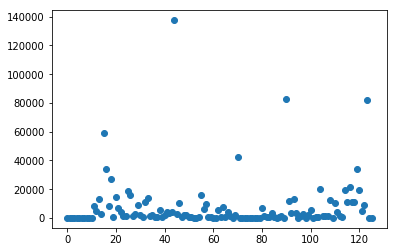

In [9]:
plt.scatter(np.arange(len(occurences)),occurences)
occurences.count(0)

Some labels are very common, for example

In [10]:
codes.count('CCAT')

137531

In [11]:
sorted([(occurences[i],c) for i,c in enumerate(topic_codes)], key=lambda x: -x[0])[:10]

[(137531, 'CCAT'),
 (82580, 'GCAT'),
 (81940, 'MCAT'),
 (59207, 'C15'),
 (42374, 'ECAT'),
 (33963, 'C151'),
 (33786, 'M14'),
 (27095, 'C152'),
 (21499, 'M13'),
 (20042, 'GPOL')]

In [12]:
commonCodes = list(map(lambda x: x[1],sorted([(occurences[i],c) for i,c in enumerate(topic_codes)], key=lambda x: -x[0])))

## Pytorch dataset

Download pretrained Global Vectors (GloVe) embeddings with `torchtext`.

In [7]:
from torchtext import datasets, vocab

glove = vocab.GloVe(name='6B', dim=100)

Dataset from a Pandas dataframe. Now we take the headline and append up to 500 characters from text and tokenize that. Targets are binary vectors of length `len(topic_codes)`.

In [8]:
# If token sequence is too short, use this index as padding.
pad_idx = 400000-1

class ReutersDataset(Dataset):
    def __init__(self, df):
        self.df = df
        
    def __getitem__(self, index):
        # For now, return simply the headline
        # and corresponding codes. We have to
        # think what we actually want to feed
        # into our model.
        data = self.df.iloc[index]
        h,t,txt,cs = data.headline, data.title, data.text, data.codes
        return self.newsToTensor(h,txt), self.codesToTensor(cs)

    def __len__(self):
        return len(self.df)
    
    def codesToTensor(self, codes):
        indices = [topic_codes.index(c) for c in codes]
        target = torch.zeros(len(topic_codes))
        for i in indices:
            target[i] = 1
        return target

    def newsToTensor(self, h, txt):
        # How many characters to take from txt
        max_txt_len = 500
        txt = txt if txt is not None else ""
        txt = txt if len(txt) < max_txt_len else txt[:max_txt_len]
        h = h if h is not None else ""
        feature = h + " " + txt
        return torch.tensor(self.tokenize(feature))
        
    def tokenize(self, txt):
        words = txt.lower().split()
        tokens = [glove.stoi[word] for word in words if word in glove.stoi]
        # This number has to be adjusted to be at least the size of our largest convolution,
        # otherwise the first convolutions will be undefined.
        min_len = 5
        tokens = tokens if len(tokens) >= min_len else tokens + ([pad_idx]*min_len-len(tokens))
        return tokens

Most of our training examples are of different lengths, so we must pad examples such that all examples in a batch have the same length. We'll pad to the length of the longest example in a batch. I don't know if `pytorch` can do this automatically, so I'll give a modified `collate_fn` for our data loaders.

In [9]:
# This assumes that the tensor is rank one
# and that it's shorter than 'length'.
def pad_to_length(tensor, length):
    return F.pad(tensor, (0, length-tensor.shape[0]), 'constant', pad_idx)

def pad_collate(batch):
    max_len = max(map(lambda example: len(example[0]), batch))
    xs = [tup[0] for tup in batch]
    xs = torch.stack(list(map(lambda x: pad_to_length(x,max_len), xs)))
    ys = torch.stack([example[1] for example in batch])
    return xs, ys

Instantiate the dataset and get data loaders. The training dataset is split into `train_set` and `test_set`.

In [10]:
train_set = ReutersDataset(df.sample(frac=0.9, random_state=42))
test_set = ReutersDataset(df.drop(train_set.df.index))

batch_size = 512
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size,
                                           collate_fn=pad_collate, shuffle=True, num_workers=4)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size,
                                          collate_fn=pad_collate, shuffle=False, num_workers=4)

## Model

Choose a device

In [42]:
import utils
import models

In [12]:
if torch.cuda.is_available():
    print('Using GPU!')
    device = torch.device('cuda')
else:
    print('Using CPU')
    device = torch.device('cpu')

Using GPU!


Choose a model

In [49]:
model = models.CNN(glove, num_filters=300, filter_sizes=[3,4,5],
                   compact_dim=63, output_dim=len(topic_codes),
                   dropout=0.0).to(device)

In [46]:
model = models.GRU(glove, hidden_dim=128, num_layers=2,
                   bidirectional=True, output_dim=126).to(device)

Check that model outputs what we expect.

In [50]:
example = next(iter(train_loader))[0].to(device)
print(example.shape) # Should be [batch_size,len(longest example in batch)]
model(example).shape # Should be [batch_size,output_size]

torch.Size([512, 152])


torch.Size([512, 126])

In [35]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
%autoreload

Functions for training and validation.

Actual training

In [51]:
criterion = nn.BCEWithLogitsLoss()
parameters = model.parameters()
optimizer = optim.Adam(parameters)

epochs = 2
losst, lossv = [], []
utils.validate(model, test_loader, criterion, [])
for epoch in range(1, epochs + 1):
    utils.train(model, train_loader, criterion, optimizer, epoch, epochs, losst)
    utils.validate(model, test_loader, criterion, lossv)
    if lossv[-1] == min(lossv):
        # Current best model, push to disk
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losst': losst[-1],
            'lossv': lossv[-1]
            }, 'train/checkpoint.pkl')


Validating...
Validation set: Average loss: 0.7014	 F1-score: 0.0635

Epoch: 1 [38400/269796 (14%)]	Loss: 0.074621	Inputs/s: 5932.0	Remaining: 1.4 min
Epoch: 1 [76800/269796 (28%)]	Loss: 0.057251	Inputs/s: 6074.9	Remaining: 1.3 min
Epoch: 1 [115200/269796 (43%)]	Loss: 0.045497	Inputs/s: 6173.2	Remaining: 1.1 min
Epoch: 1 [153600/269796 (57%)]	Loss: 0.034853	Inputs/s: 6198.0	Remaining: 1.0 min
Epoch: 1 [192000/269796 (71%)]	Loss: 0.030727	Inputs/s: 6211.0	Remaining: 0.9 min
Epoch: 1 [230400/269796 (85%)]	Loss: 0.033191	Inputs/s: 6227.4	Remaining: 0.8 min
Epoch: 1 [268800/269796 (100%)]	Loss: 0.030853	Inputs/s: 6227.3	Remaining: 0.7 min

Validating...
Validation set: Average loss: 0.0306	 F1-score: 0.7705

Epoch: 2 [38400/269796 (14%)]	Loss: 0.029433	Inputs/s: 5918.5	Remaining: 0.7 min
Epoch: 2 [76800/269796 (28%)]	Loss: 0.025403	Inputs/s: 6075.7	Remaining: 0.5 min
Epoch: 2 [115200/269796 (43%)]	Loss: 0.027821	Inputs/s: 6129.7	Remaining: 0.4 min
Epoch: 2 [153600/269796 (57%)]	Loss: 0.02

Some plots of losses per epoch.

Text(0.5, 1.0, 'loss vs epoch')

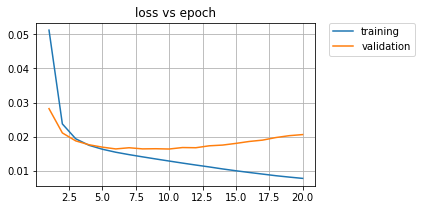

In [32]:
plt.figure(figsize=(5,3))
plt.plot(np.arange(1,len(losst)+1), losst, label="training")
plt.plot(np.arange(1,len(lossv)+1), lossv, label="validation")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid()
plt.title('loss vs epoch')

Checkpoint loading

In [35]:
model = Model().to(device)
optimizer = optim.Adam(model.parameters())

checkpoint = torch.load('train/checkpoint.pkl')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
print('Epoch:', checkpoint['epoch'])
print('losst:', checkpoint['losst'])
print('lossv:', checkpoint['lossv'])
model.eval()

Epoch: 10
losst: 0.012859820469549418
lossv: 0.016382071031731064


Model(
  (embedding): Embedding(400000, 100)
  (gru): GRU(100, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=1024, out_features=126, bias=True)
)

In [33]:
losst[-1], lossv[-1]

(0.0077796714014569885, 0.020609828817137216)

In [34]:
min(losst), min(lossv)

(0.0077796714014569885, 0.016382071031731064)

With default Adam settings we have observed

| Epochs | B. size | Train loss | Val. loss | Overfit        | Train speed | Architecture | Test F1
|--------|---------|------------|-----------|----------------|-------------|--------------|----------
|     20 |     512 |   0.017896 |  0.019643 | No             |    4.0k i/s | glove(100,static)-2xGRU(64,0.5)-fc(126)
|     20 |     512 |   0.014580 |  0.017506 | No             |    4.2k i/s | glove(100,static)-2xGRU(128,0.5)-fc(126)
|     20 |     512 |   0.010958 |  0.018033 (0.016747) | Slight, e=11   |    3.9k i/s | glove(100,static)-2xGRU(256,0.5)-fc(126)
|     20 |     512 |   0.010131 |  0.017633 (0.016314) | Slight, e=11   |    1.5k i/s | glove(100,static)-2xGRU(512,0.5)-fc(126)
|--------|---------|------------|-----------|----------------|-------------|-------------
|     20 |     512 |   0.017134 |  0.018967 | No             |    2.9k i/s | glove(100,static)-3xGRU(64,0.5)-fc(126)
|     20 |     512 |   0.013934 |  0.017119 (0.017075) | No-ish         |    2.9k i/s | glove(100,static)-3xGRU(128,0.5)-fc(126)
|     20 |     512 |   0.010776 |  0.018129 (0.016653) | Slight, e=14   |    2.6k i/s | glove(100,static)-3xGRU(256,0.5)-fc(126)
|     20 |     512 |   0.008410 |  0.019950 (0.016148) | Slight, e=10   |    ?.?k i/s | glove(100,static)-3xGRU(512,0.5)-fc(126)
|--------|---------|------------|-----------|----------------|-------------|-------------
|     20 |     512 |   0.015135 |  0.017764 | No             |    3.7k i/s | glove(100,static)-2xBiGRU(64,0.5)-fc(126) | 0.890767
|     20 |     512 |   0.012389 |  0.017930 (0.017071) | Slight, e=?       |    5.1k i/s | glove(100,static)-2xBiGRU(128,0.5)-fc(126) | 0.895
|     20 |     512 |   0.007780 |  0.020610 (0.016382) | Moderate, e=10   |    1.9k i/s | glove(100,static)-2xBiGRU(256,0.5)-fc(126) | 0.884209
|     10 |     512 |   0.009912 |  0.017856 (**0.016121**) | Moderate, e=7   |    ?.?k i/s | glove(100,static)-2xBiGRU(512,0.5)-fc(126) | 0.886063

Best validation loss: **0.016121**

## Download test set

The testset will be made available during the last week before the deadline and can be downloaded in the same way as the training set.

In [35]:
import os
from torchvision.datasets.utils import download_url

train_path='train/test/'
dl_url='http://bsnlp-2017.cs.helsinki.fi/REUTERSX/REUTERS_CORPUS_2_TEST_strip/'
dl_files=['19970410-test.zip','19970420-test.zip','19970430-test.zip','19970510-test.zip','19970520-test.zip',
         '19970530-test.zip','19970609-test.zip','19970619-test.zip','19970629-test.zip','19970709-test.zip',
         '19970719-test.zip','19970729-test.zip','19970808-test.zip','19970818-test.zip']

for dl_file in dl_files:
    if not os.path.isfile(train_path+dl_file):
        download_url(dl_url+dl_file, root=train_path, filename=dl_file, md5=None)

In [38]:
import zipfile

def parseXML(file):
    root = ET.parse(file).getroot()
    return getHeadline(root), getTitle(root), getText(root)

def parseZip(file):
    zf = zipfile.ZipFile(file, 'r')
    for xml in zf.namelist():
        h,t,txt = parseXML(zf.open(xml))
        headlines.append(h)
        titles.append(t)
        texts.append(txt)

data_path = 'train/test/'
headlines, titles, texts = [], [], []
print('Processing data in', data_path)
for f in os.listdir(data_path):
    if f.endswith(".zip"):
        print('.', end='')
        parseZip(data_path+f)

test_df = pd.DataFrame({'headline': headlines, 'title': titles, 'text': texts})
print('\nCompressing dataframe to train/test.json.xz')
test_df.to_json('train/test.json.xz', orient='records', compression='xz')
test_df.head()

Processing data in train/test/
..............
Compressing dataframe to train/test.json.xz


,headline,title,text
0,PRESS DIGEST - SOUTH AFRICA - APRIL 10.,SOUTH AFRICA: PRESS DIGEST - SOUTH AFRICA - AP...,These are the leading stories in the South Afr...
1,OFFICIAL JOURNAL CONTENTS - OJ C 110 OF APRIL ...,EU: OFFICIAL JOURNAL CONTENTS - OJ C 110 OF A...,*\n(Note - contents are displayed in reverse o...
2,OFFICIAL JOURNAL CONTENTS - OJ L 94 OF APRIL 9...,EU: OFFICIAL JOURNAL CONTENTS - OJ L 94 OF AP...,*\n(Note - contents are displayed in reverse o...
3,OFFICIAL JOURNAL CONTENTS - OJ C 55 OF FEBRUAR...,EU: OFFICIAL JOURNAL CONTENTS - OJ C 55 OF FE...,"*\nMinutes of the sitting of Wednesday, 29 Jan..."
4,Toronto stocks close easier in lackluster deal...,CANADA: Toronto stocks close easier in lacklus...,CHANGE\t\t\t\t CHANGE\nTSE\t 5790.11 -...


## Load a previously downloaded test set

In [39]:
test_df = pd.read_json('train/test.json.xz', compression='xz')
test_df.head()

,headline,text,title
0,PRESS DIGEST - SOUTH AFRICA - APRIL 10.,These are the leading stories in the South Afr...,SOUTH AFRICA: PRESS DIGEST - SOUTH AFRICA - AP...
1,OFFICIAL JOURNAL CONTENTS - OJ C 110 OF APRIL ...,*\n(Note - contents are displayed in reverse o...,EU: OFFICIAL JOURNAL CONTENTS - OJ C 110 OF A...
2,OFFICIAL JOURNAL CONTENTS - OJ L 94 OF APRIL 9...,*\n(Note - contents are displayed in reverse o...,EU: OFFICIAL JOURNAL CONTENTS - OJ L 94 OF AP...
3,OFFICIAL JOURNAL CONTENTS - OJ C 55 OF FEBRUAR...,"*\nMinutes of the sitting of Wednesday, 29 Jan...",EU: OFFICIAL JOURNAL CONTENTS - OJ C 55 OF FE...
4,Toronto stocks close easier in lackluster deal...,CHANGE\t\t\t\t CHANGE\nTSE\t 5790.11 -...,CANADA: Toronto stocks close easier in lacklus...


Test set doesn't have codes, so using it with our existing dataset will hang. To circumvent this, I'll add a blank set of codes for every row.

In [40]:
test_df['codes']=[[]]*len(test_df)

In [41]:
test_df = clean_df(test_df)

## Predict for test set

You will be asked to return your predictions a separate test set.  These should be returned as a matrix with one row for each test article.  Each row contains a binary prediction for each label, 1 if it's present in the image, and 0 if not. The order of the labels is the order of the label (topic) codes.

An example row could like like this if your system predicts the presense of the second and fourth topic:

    0 1 0 1 0 0 0 0 0 0 0 0 0 0 ...
    
If you have the matrix prepared in `y` you can use the following function to save it to a text file.

This function will iterate through a given dataset and predict labels using our model. Result is a matrix where each example has a vector of size `output_dim` storing the predicted labels.

Build a dataset for `test_df` and calculate predictions.

In [43]:
competition_set = ReutersDataset(test_df)

batch_size = 64
competition_loader = torch.utils.data.DataLoader(dataset=competition_set, batch_size=batch_size,
                                           collate_fn=pad_collate, shuffle=False, num_workers=4)

prediction = utils.predict(model, competition_loader)

Average number of labels predicted by the model is

In [45]:
np.mean([np.sum(p) for p in prediction])

2.747359845513246

Save predictions to `results.txt`

In [46]:
np.savetxt('results.txt', prediction, fmt='%d')